In [1]:
import json
import gc
import os
import itertools
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.base import clone
from sklearn.utils.class_weight import compute_sample_weight

from tqdm.notebook import tqdm
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')


class CFG:
    # Đường dẫn lowercase cho Kaggle
    train_path = "/kaggle/input/MABe-mouse-behavior-detection/train.csv"
    test_path = "/kaggle/input/MABe-mouse-behavior-detection/test.csv"
    train_annotation_path = "/kaggle/input/MABe-mouse-behavior-detection/train_annotation"
    train_tracking_path = "/kaggle/input/MABe-mouse-behavior-detection/train_tracking"
    test_tracking_path = "/kaggle/input/MABe-mouse-behavior-detection/test_tracking"

    n_splits = 3
    neg_sample_ratio = 0.3  # Chỉ lấy 30% negative frames để giảm RAM
    pos_sample_ratio = 0.8  # Giữ lại 80% positive frames
    use_class_weights = True  # Có sử dụng class weights
    
    # Model cải tiến với advanced parameters - ĐÃ SỬA: LOẠI BỎ early_stopping_rounds
    model = XGBClassifier(
        verbosity=0,
        random_state=42,
        n_estimators=500,           # Tăng số cây
        learning_rate=0.03,         # Giảm learning rate để hội tụ tốt hơn
        max_depth=8,                # Tăng độ sâu cho features phức tạp
        min_child_weight=2,         # Giảm để capture patterns nhỏ
        subsample=0.7,              # Giảm để chống overfitting
        colsample_bytree=0.7,
        gamma=0.1,                  # Thêm min split loss
        reg_alpha=0.01,             # L1 regularization
        reg_lambda=1,               # L2 regularization
        tree_method="hist",
        device="cuda",
        n_jobs=-1,
        enable_categorical=False,
        eval_metric="mlogloss",     # Thêm eval metric
        # ĐÃ LOẠI BỎ: early_stopping_rounds=50   # Không dùng ở đây, sẽ dùng trong training
    )

print("Enhanced Config loaded.")

Enhanced Config loaded.


In [2]:
# Cell B: Load data - ĐÃ SỬA LỖI

train = pd.read_csv(CFG.train_path)
test = pd.read_csv(CFG.test_path)

train["n_mice"] = 4 - train[["mouse1_strain", "mouse2_strain", "mouse3_strain", "mouse4_strain"]].isna().sum(axis=1)
train_without_mbae = train.query("~lab_id.str.startswith('MABe22_')").reset_index(drop=True)  # ĐÃ SỬA

# Dùng 8 body parts quan trọng
IMPORTANT_PARTS = ["body_center", "nose", "tail_base", "ear_left", "ear_right", "neck", "lateral_left", "lateral_right"]

body_parts_tracked_all = sorted(
    set(sum((json.loads(s) for s in train["body_parts_tracked"].dropna().tolist()), []))
)
body_parts_tracked_list = [p for p in IMPORTANT_PARTS if p in body_parts_tracked_all]

fps_lookup = dict(zip(train["video_id"], train["frames_per_second"]))
fps_lookup.update(dict(zip(test["video_id"], test["frames_per_second"])))

print("train:", train.shape)
print("train_without_mbae:", train_without_mbae.shape)
print("Body parts dùng:", body_parts_tracked_list)

train: (8789, 39)
train_without_mbae: (863, 39)
Body parts dùng: ['body_center', 'nose', 'tail_base', 'ear_left', 'ear_right', 'neck', 'lateral_left', 'lateral_right']


In [3]:
DROP_BODY_PARTS = [
    'headpiece_bottombackleft', 'headpiece_bottombackright',
    'headpiece_bottomfrontleft', 'headpiece_bottomfrontright',
    'headpiece_topbackleft', 'headpiece_topbackright',
    'headpiece_topfrontleft', 'headpiece_topfrontright',
    'spine_1', 'spine_2',
    'tail_middle_1', 'tail_middle_2', 'tail_midpoint'
]

def scaled_window(n_frames_30fps, fps, min_frac=0.2, min_abs=1):
    ws = max(1, int(round(n_frames_30fps * float(fps) / 30.0)))
    min_periods = max(min_abs, int(round(ws * min_frac)))
    return ws, min_periods

def _scale(n_frames_at_30fps, fps, ref=30.0):
    return max(1, int(round(n_frames_at_30fps * float(fps) / ref)))

def _scale_signed(n_frames_at_30fps, fps, ref=30.0):
    if n_frames_at_30fps == 0:
        return 0
    s = 1 if n_frames_at_30fps > 0 else -1
    mag = max(1, int(round(abs(n_frames_at_30fps) * float(fps) / ref)))
    return s * mag

print("Helpers loaded.")

Helpers loaded.


In [4]:
# Cell D: Advanced Feature Engineering Functions - ĐÃ SỬA LỖI

# ============================================================================
# ADVANCED FEATURE ENGINEERING FUNCTIONS TỪ NOTEBOOK 2
# ============================================================================

def add_curvature_features(X, center_x, center_y, fps):
    """Thêm curvature features từ notebook 2"""
    # velocity & acceleration
    vx = center_x.diff()
    vy = center_y.diff()
    ax = vx.diff()
    ay = vy.diff()

    # curvature = |v × a| / |v|^3
    cross = vx * ay - vy * ax
    speed = np.sqrt(vx**2 + vy**2)
    curvature = np.abs(cross) / (speed**3 + 1e-6)

    # rolling curvature mean
    for base_w in [25, 50]:
        ws = _scale(base_w, fps)
        X[f'curv_mean_{base_w}'] = curvature.rolling(ws, min_periods=1).mean()
    
    # turning rate
    angle = np.arctan2(vy, vx)
    angle_change = np.abs(angle.diff())
    ws = _scale(30, fps)
    X['turn_rate_30'] = angle_change.rolling(ws, min_periods=1).mean()
    
    return X

def add_multiscale_features(X, center_x, center_y, fps):
    """Thêm multi-scale speed features từ notebook 2"""
    speed = np.sqrt(center_x.diff()**2 + center_y.diff()**2) * float(fps)
    
    scales = [20, 40, 60]
    for base_w in scales:
        ws = _scale(base_w, fps)
        X[f'sp_m{base_w}'] = speed.rolling(ws, min_periods=1).mean()
        X[f'sp_s{base_w}'] = speed.rolling(ws, min_periods=1).std()
    
    if all(f"sp_m{s}" in X.columns for s in (scales[0], scales[-1])):
        X['sp_ratio'] = X[f'sp_m{scales[0]}'] / (X[f'sp_m{scales[-1]}'] + 1e-6)  # ĐÃ SỬA
    
    return X

def add_state_features(X, center_x, center_y, fps):
    """Thêm state features từ notebook 2"""
    speed = np.sqrt(center_x.diff()**2 + center_y.diff()**2) * float(fps)
    
    ws_ma = _scale(15, fps)
    speed_ma = speed.rolling(ws_ma, min_periods=1).mean()
    
    try:
        bins = [-np.inf, 0.5 * fps, 2.0 * fps, 5.0 * fps, np.inf]
        speed_states = pd.cut(speed_ma, bins=bins, labels=[0, 1, 2, 3]).astype(float)
        
        for base_w in [20, 40]:
            ws = _scale(base_w, fps)
            for state in [0, 1, 2, 3]:
                X[f's{state}_{base_w}'] = (
                    (speed_states == state)
                    .astype(float)
                    .rolling(ws, min_periods=1)
                    .mean()
                )
            
            state_changes = (speed_states != speed_states.shift(1)).astype(float)
            X[f'trans_{base_w}'] = state_changes.rolling(ws, min_periods=1).sum()
    except Exception:
        pass
    
    return X

def add_longrange_features(X, center_x, center_y, fps):
    """Thêm long-range features từ notebook 2"""
    # long-range moving average
    for base_w in [30, 60, 120]:
        ws = _scale(base_w, fps)
        X[f'x_ml{base_w}'] = center_x.rolling(ws, min_periods=1).mean()
        X[f'y_ml{base_w}'] = center_y.rolling(ws, min_periods=1).mean()
    
    # EWMA
    for span in [30, 60]:
        ws = _scale(span, fps)
        X[f'x_e{span}'] = center_x.ewm(span=ws, min_periods=1).mean()
        X[f'y_e{span}'] = center_y.ewm(span=ws, min_periods=1).mean()
    
    # percentile rank of speed
    speed = np.sqrt(center_x.diff()**2 + center_y.diff()**2) * float(fps)
    for base_w in [30, 60]:
        ws = _scale(base_w, fps)
        X[f'sp_pct{base_w}'] = speed.rolling(ws, min_periods=1).rank(pct=True)
    
    return X

def add_interaction_features(X, mouse_pair, avail_A, avail_B, fps):
    """Thêm interaction features từ notebook 2 cho pair behaviors"""
    if "body_center" not in avail_A or "body_center" not in avail_B:
        return X
    
    # coordinates
    Ax = mouse_pair["A"]["body_center"]["x"]
    Ay = mouse_pair["A"]["body_center"]["y"]
    Bx = mouse_pair["B"]["body_center"]["x"]
    By = mouse_pair["B"]["body_center"]["y"]
    
    # relative position
    rel_x = Ax - Bx
    rel_y = Ay - By
    rel_dist = np.sqrt(rel_x**2 + rel_y**2)
    
    # velocity
    A_vx = Ax.diff()
    A_vy = Ay.diff()
    B_vx = Bx.diff()
    B_vy = By.diff()
    
    # cosine angle between (A,B) vector and velocity vector
    A_lead = (A_vx * rel_x + A_vy * rel_y) / (np.sqrt(A_vx**2 + A_vy**2) * rel_dist + 1e-6)
    B_lead = (B_vx * (-rel_x) + B_vy * (-rel_y)) / (np.sqrt(B_vx**2 + B_vy**2) * rel_dist + 1e-6)  # ĐÃ SỬA
    
    # rolling means
    for base_w in [30, 60]:
        ws = _scale(base_w, fps)
        X[f'A_lead_{base_w}'] = A_lead.rolling(ws, min_periods=1).mean()
        X[f'B_lead_{base_w}'] = B_lead.rolling(ws, min_periods=1).mean()
    
    # chase feature
    approach = -rel_dist.diff()
    chase = approach * B_lead
    ws = _scale(30, fps)
    X['chase_30'] = chase.rolling(ws, min_periods=1).mean()
    
    # speed correlation
    A_sp = np.sqrt(A_vx**2 + A_vy**2)
    B_sp = np.sqrt(B_vx**2 + B_vy**2)
    for base_w in [60, 120]:
        ws = _scale(base_w, fps)
        X[f'sp_corr_{base_w}'] = A_sp.rolling(ws, min_periods=1).corr(B_sp)
    
    return X

print("Advanced feature engineering functions loaded.")

Advanced feature engineering functions loaded.


In [5]:
# ============================================================================
# ENHANCED TRANSFORM FUNCTIONS
# ============================================================================

def transform_pair(mouse_pair, body_parts, fps):
    """Feature engineering cho pair behaviors - Enhanced version"""
    avail_A = set(mouse_pair['A'].columns.get_level_values(0))
    avail_B = set(mouse_pair['B'].columns.get_level_values(0))
    
    features = {}
    
    # 1. Pairwise distance - chỉ các cặp quan trọng
    key_pairs = [
        ('body_center', 'body_center'),
        ('nose', 'nose'),
        ('nose', 'tail_base'),
        ('tail_base', 'nose'),
        ('nose', 'body_center'),
        ('body_center', 'nose'),
    ]
    
    for p1, p2 in key_pairs:
        if p1 in avail_A and p2 in avail_B:
            diff = mouse_pair['A'][p1] - mouse_pair['B'][p2]
            features[f"d_{p1}_{p2}"] = np.sqrt((diff**2).sum(axis=1))
    
    X = pd.DataFrame(features, index=mouse_pair.index)
    
    # 2. Body center features (cơ bản)
    if 'body_center' in avail_A and 'body_center' in avail_B:
        Ax = mouse_pair['A']['body_center']['x']
        Ay = mouse_pair['A']['body_center']['y']
        Bx = mouse_pair['B']['body_center']['x']
        By = mouse_pair['B']['body_center']['y']
        
        # Distance
        cd = np.sqrt((Ax - Bx)**2 + (Ay - By)**2)
        X['dist'] = cd
        
        # Distance bins (cải tiến thêm bins)
        X['dist_very_close'] = (cd < 2.0).astype(np.float32)
        X['dist_close'] = ((cd >= 2.0) & (cd < 5.0)).astype(np.float32)
        X['dist_medium'] = ((cd >= 5.0) & (cd < 12.0)).astype(np.float32)
        X['dist_far'] = ((cd >= 12.0) & (cd < 25.0)).astype(np.float32)
        X['dist_very_far'] = (cd >= 25.0).astype(np.float32)
        
        # Velocity features
        Avx, Avy = Ax.diff(), Ay.diff()
        Bvx, Bvy = Bx.diff(), By.diff()
        
        A_speed = np.sqrt(Avx**2 + Avy**2)
        B_speed = np.sqrt(Bvx**2 + Bvy**2)
        X['A_speed'] = A_speed
        X['B_speed'] = B_speed
        X['speed_diff'] = A_speed - B_speed
        X['speed_sum'] = A_speed + B_speed
        
        # Approach/retreat features
        X['approach'] = -cd.diff()  # positive = approaching
        
        # Velocity alignment
        vel_dot = Avx * Bvx + Avy * Bvy
        vel_norm = (np.sqrt(Avx**2 + Avy**2) * np.sqrt(Bvx**2 + Bvy**2) + 1e-6)
        X['vel_cos'] = vel_dot / vel_norm
        
        # Relative velocity magnitude
        X['rel_vel_mag'] = np.sqrt((Avx - Bvx)**2 + (Avy - Bvy)**2)
        
        # Rolling stats (cải tiến thêm nhiều windows)
        windows = [10, 20, 30, 45, 60, 90]
        for w in windows:
            ws = _scale(w, fps)
            X[f'dist_mean_{w}'] = cd.rolling(ws, min_periods=1).mean()
            X[f'dist_std_{w}'] = cd.rolling(ws, min_periods=1).std()
            X[f'dist_min_{w}'] = cd.rolling(ws, min_periods=1).min()
            X[f'dist_max_{w}'] = cd.rolling(ws, min_periods=1).max()
            X[f'A_speed_mean_{w}'] = A_speed.rolling(ws, min_periods=1).mean()
            X[f'B_speed_mean_{w}'] = B_speed.rolling(ws, min_periods=1).mean()
            X[f'approach_sum_{w}'] = X['approach'].rolling(ws, min_periods=1).sum()
        
        # ====================================================================
        # THÊM ADVANCED INTERACTION FEATURES TỪ NOTEBOOK 2
        # ====================================================================
        X = add_interaction_features(X, mouse_pair, avail_A, avail_B, fps)
    
    # 3. Orientation features (cải tiến)
    if all(p in avail_A for p in ['nose', 'tail_base']) and all(p in avail_B for p in ['nose', 'tail_base']):
        dir_A = mouse_pair['A']['nose'] - mouse_pair['A']['tail_base']
        dir_B = mouse_pair['B']['nose'] - mouse_pair['B']['tail_base']
        
        dot = dir_A['x'] * dir_B['x'] + dir_A['y'] * dir_B['y']
        nA = np.sqrt(dir_A['x']**2 + dir_A['y']**2) + 1e-6
        nB = np.sqrt(dir_B['x']**2 + dir_B['y']**2) + 1e-6
        X['ori_cos'] = dot / (nA * nB)
        
        # A/B facing features
        if 'body_center' in avail_A and 'body_center' in avail_B:
            # A facing B
            to_B = mouse_pair['B']['body_center'] - mouse_pair['A']['body_center']
            facing_dot = dir_A['x'] * to_B['x'] + dir_A['y'] * to_B['y']
            to_B_norm = np.sqrt(to_B['x']**2 + to_B['y']**2) + 1e-6
            X['A_facing_B'] = facing_dot / (nA * to_B_norm)
            
            # B facing A
            to_A = mouse_pair['A']['body_center'] - mouse_pair['B']['body_center']
            facing_dot_B = dir_B['x'] * to_A['x'] + dir_B['y'] * to_A['y']
            to_A_norm = np.sqrt(to_A['x']**2 + to_A['y']**2) + 1e-6
            X['B_facing_A'] = facing_dot_B / (nB * to_A_norm)
            
            # Angle difference
            X['facing_angle_diff'] = X['A_facing_B'] - X['B_facing_A']
    
    # 4. Nose-to-nose specific features
    if 'nose' in avail_A and 'nose' in avail_B:
        nose_diff = mouse_pair['A']['nose'] - mouse_pair['B']['nose']
        nose_dist = np.sqrt((nose_diff**2).sum(axis=1))
        X['nose_dist'] = nose_dist
        X['nose_close'] = (nose_dist < 3.0).astype(np.float32)
        
        # Nose approach rate
        X['nose_approach'] = -nose_dist.diff()
    
    # 5. Ear features (nếu có)
    ear_parts = ['ear_left', 'ear_right']
    if all(p in avail_A for p in ear_parts) and all(p in avail_B for p in ear_parts):
        # Ear distance symmetry
        A_ear_dist = np.sqrt(((mouse_pair['A']['ear_left'] - mouse_pair['A']['ear_right'])**2).sum(axis=1))
        B_ear_dist = np.sqrt(((mouse_pair['B']['ear_left'] - mouse_pair['B']['ear_right'])**2).sum(axis=1))
        X['ear_dist_ratio'] = A_ear_dist / (B_ear_dist + 1e-6)
    
    return X.astype(np.float32)


def transform_single(single_mouse, body_parts, fps):
    """Feature engineering cho single behaviors - Enhanced version"""
    avail = set(single_mouse.columns.get_level_values(0))
    features = {}
    
    # 1. Basic speed and acceleration
    if 'body_center' in avail:
        cx = single_mouse['body_center']['x']
        cy = single_mouse['body_center']['y']
        
        # Speed và acceleration
        vx, vy = cx.diff(), cy.diff()
        speed = np.sqrt(vx**2 + vy**2)
        features['speed'] = speed
        features['accel'] = speed.diff()
        
        # Jerk (rate of change of acceleration)
        features['jerk'] = features['accel'].diff()
        
        # Movement angle
        features['mov_angle'] = np.arctan2(vy, vx)
        features['angle_change'] = np.abs(features['mov_angle'].diff())
        
        # ====================================================================
        # THÊM ADVANCED FEATURES TỪ NOTEBOOK 2
        # ====================================================================
        X_basic = pd.DataFrame(features, index=single_mouse.index)
        
        # Thêm curvature features
        X_basic = add_curvature_features(X_basic, cx, cy, fps)
        
        # Thêm multi-scale features
        X_basic = add_multiscale_features(X_basic, cx, cy, fps)
        
        # Thêm state features
        X_basic = add_state_features(X_basic, cx, cy, fps)
        
        # Thêm long-range features
        X_basic = add_longrange_features(X_basic, cx, cy, fps)
        
        # Rolling stats cải tiến
        windows = [10, 20, 30, 45, 60, 90]
        for w in windows:
            ws = _scale(w, fps)
            X_basic[f'speed_mean_{w}'] = speed.rolling(ws, min_periods=1).mean()
            X_basic[f'speed_std_{w}'] = speed.rolling(ws, min_periods=1).std()
            X_basic[f'speed_max_{w}'] = speed.rolling(ws, min_periods=1).max()
            X_basic[f'speed_min_{w}'] = speed.rolling(ws, min_periods=1).min()
            X_basic[f'accel_mean_{w}'] = X_basic['accel'].rolling(ws, min_periods=1).mean()
            X_basic[f'angle_change_sum_{w}'] = X_basic['angle_change'].rolling(ws, min_periods=1).sum()
        
        # Movement consistency
        X_basic['movement_consistency'] = X_basic['speed_std_30'] / (X_basic['speed_mean_30'] + 1e-6)
        
        # Position volatility
        X_basic['x_volatility'] = cx.rolling(_scale(30, fps), min_periods=1).std()
        X_basic['y_volatility'] = cy.rolling(_scale(30, fps), min_periods=1).std()
        
        # Đã có X_basic, tiếp tục thêm các features khác
        X = X_basic
    else:
        X = pd.DataFrame(features, index=single_mouse.index)
    
    # 2. Body length và shape features
    if 'nose' in avail and 'tail_base' in avail:
        diff = single_mouse['nose'] - single_mouse['tail_base']
        body_len = np.sqrt((diff**2).sum(axis=1))
        X['body_len'] = body_len
        
        # Body length dynamics
        X['body_len_change'] = body_len.diff()
        X['body_len_var'] = body_len.rolling(_scale(30, fps), min_periods=1).var()
        
        for w in [15, 30, 60]:
            ws = _scale(w, fps)
            X[f'body_len_mean_{w}'] = body_len.rolling(ws, min_periods=1).mean()
            X[f'body_len_std_{w}'] = body_len.rolling(ws, min_periods=1).std()
            X[f'body_len_cv_{w}'] = X[f'body_len_std_{w}'] / (X[f'body_len_mean_{w}'] + 1e-6)
    
    # 3. Head/ear features (head orientation)
    if 'ear_left' in avail and 'ear_right' in avail:
        ear_diff = single_mouse['ear_left'] - single_mouse['ear_right']
        ear_dist = np.sqrt((ear_diff**2).sum(axis=1))
        X['ear_dist'] = ear_dist
        
        # Ear distance dynamics
        X['ear_dist_change'] = ear_dist.diff()
        X['ear_dist_var'] = ear_dist.rolling(_scale(30, fps), min_periods=1).var()
        
        # Head width consistency
        X['head_consistency'] = ear_dist.rolling(_scale(30, fps), min_periods=1).std() / \
                               (ear_dist.rolling(_scale(30, fps), min_periods=1).mean() + 1e-6)
    
    # 6. Fill NaN và ensure float32
    X = X.fillna(0.0).astype(np.float32)
    
    return X

print("Enhanced transform functions loaded.")

Enhanced transform functions loaded.


In [6]:
def generate_mouse_data(dataset, mode='pair', is_train=True):
    data_dir = CFG.train_tracking_path if is_train else CFG.test_tracking_path

    for _, row in dataset.iterrows():
        lab_id = row.lab_id
        if str(lab_id).startswith("MABe22") or not isinstance(row.behaviors_labeled, str):
            continue

        video_id = row.video_id
        tracking_path = f"{data_dir}/{lab_id}/{video_id}.parquet"

        try:
            vid = pd.read_parquet(tracking_path)
        except FileNotFoundError:
            continue

        # Drop unnecessary body parts
        if len(np.unique(vid.bodypart)) > 8:
            vid = vid.query("~bodypart.isin(@DROP_BODY_PARTS)")

        pvid = vid.pivot(
            index="video_frame",
            columns=["mouse_id", "bodypart"],
            values=["x", "y"],
        )
        del vid
        gc.collect()

        pvid = pvid.reorder_levels([1, 2, 0], axis=1).T.sort_index().T
        pvid = pvid / row.pix_per_cm_approx

        raw_behaviors = json.loads(row.behaviors_labeled)
        cleaned = {b.replace("'", "") for b in raw_behaviors}
        behaviors_split = [b.split(",") for b in sorted(cleaned)]
        vid_beh = pd.DataFrame(behaviors_split, columns=["agent", "target", "action"])

        if is_train:
            try:
                anno_path = tracking_path.replace("train_tracking", "train_annotation")
                anno = pd.read_parquet(anno_path)
            except FileNotFoundError:
                continue

        mouse_ids = np.unique(pvid.columns.get_level_values("mouse_id"))

        # PAIR behaviors
        if mode in ['pair', 'both']:
            vid_beh_pair = vid_beh.query("target != 'self'")
            if len(vid_beh_pair) > 0:
                for agent_id, target_id in itertools.permutations(mouse_ids, 2):
                    agent_str = f"mouse{agent_id}"
                    target_str = f"mouse{target_id}"

                    pair_actions = vid_beh_pair.query(
                        "(agent == @agent_str) & (target == @target_str)"
                    ).action.unique()
                    if len(pair_actions) == 0:
                        continue

                    mouse_pair = pd.concat(
                        [pvid[agent_id], pvid[target_id]],
                        axis=1, keys=["A", "B"]
                    )

                    pair_meta = pd.DataFrame({
                        "video_id": video_id,
                        "agent_id": agent_str,
                        "target_id": target_str,
                        "video_frame": mouse_pair.index,
                    })

                    if is_train:
                        pair_label = pd.DataFrame(0.0, columns=pair_actions, index=mouse_pair.index)
                        anno_pair = anno.query("(agent_id == @agent_id) & (target_id == @target_id)")
                        for _, ar in anno_pair.iterrows():
                            if ar["action"] in pair_label.columns:
                                pair_label.loc[ar["start_frame"]:ar["stop_frame"], ar["action"]] = 1.0
                        yield "pair", mouse_pair, pair_meta, pair_label
                    else:
                        yield "pair", mouse_pair, pair_meta, list(pair_actions)

        # SINGLE behaviors
        if mode in ['single', 'both']:
            vid_beh_single = vid_beh.query("target == 'self'")
            if len(vid_beh_single) > 0:
                for mouse_id in mouse_ids:
                    agent_str = f"mouse{mouse_id}"
                    single_actions = vid_beh_single.query("agent == @agent_str").action.unique()
                    if len(single_actions) == 0:
                        continue

                    single_mouse = pvid[mouse_id]
                    single_meta = pd.DataFrame({
                        "video_id": video_id,
                        "agent_id": agent_str,
                        "target_id": "self",
                        "video_frame": single_mouse.index,
                    })

                    if is_train:
                        single_label = pd.DataFrame(0.0, columns=single_actions, index=single_mouse.index)
                        anno_single = anno.query("(agent_id == @mouse_id) & (target_id == @mouse_id)")
                        for _, ar in anno_single.iterrows():
                            if ar["action"] in single_label.columns:
                                single_label.loc[ar["start_frame"]:ar["stop_frame"], ar["action"]] = 1.0
                        yield "single", single_mouse, single_meta, single_label
                    else:
                        yield "single", single_mouse, single_meta, list(single_actions)

print("Data generator loaded.")

Data generator loaded.


In [7]:
def build_dataset(dataset, mode='both', max_items=None, frame_step=3, neg_ratio=0.3, pos_ratio=0.8):
    """
    Build dataset với improved sampling:
    - Giữ lại phần lớn positive frames
    - Lấy một phần negative frames
    - Áp dụng frame_step để giảm data
    """
    X_list = []
    y_list = []
    meta_list = []
    n_items = 0
    
    for kind, mouse_data, meta, labels in tqdm(
        generate_mouse_data(dataset, mode=mode, is_train=True),
        desc="Building enhanced dataset"
    ):
        if max_items is not None and n_items >= max_items:
            break
        n_items += 1
        
        vid = meta["video_id"].iloc[0]
        fps = fps_lookup.get(vid, 30.0)
        
        # Transform với features mới
        if kind == 'pair':
            X = transform_pair(mouse_data, body_parts_tracked_list, fps)
        else:
            X = transform_single(mouse_data, body_parts_tracked_list, fps)
        
        labels = labels.reindex(X.index).fillna(0.0)
        if labels.empty or labels.shape[1] == 0:
            continue
        
        actions = labels.columns.tolist()
        arr = labels.values
        
        # Tìm positive frames
        any_pos = arr.max(axis=1) > 0
        pos_idx = np.where(any_pos)[0]
        neg_idx = np.where(~any_pos)[0]
        
        if len(pos_idx) == 0:
            continue
        
        # Smart sampling: giữ phần lớn positive, ít negative
        n_pos_sample = max(1, int(len(pos_idx) * pos_ratio))
        n_neg_sample = max(1, int(len(neg_idx) * neg_ratio))
        
        if len(pos_idx) > n_pos_sample:
            pos_idx = np.random.choice(pos_idx, n_pos_sample, replace=False)
        if len(neg_idx) > n_neg_sample:
            neg_idx = np.random.choice(neg_idx, n_neg_sample, replace=False)
        
        # Combine và sort
        selected_idx = np.sort(np.concatenate([pos_idx, neg_idx]))
        
        # Apply frame_step
        selected_idx = selected_idx[::frame_step]
        
        # Get action names
        main_idx = arr.argmax(axis=1)
        action_names = np.array(["none"] * len(X), dtype=object)
        action_names[any_pos] = np.array(actions)[main_idx[any_pos]]
        
        X_ds = X.iloc[selected_idx]
        y_ds = pd.Series(action_names[selected_idx], index=X_ds.index)
        meta_ds = meta.iloc[selected_idx].reset_index(drop=True)
        
        X_list.append(X_ds)
        y_list.append(y_ds)
        meta_list.append(meta_ds)
        
        # Free memory
        if n_items % 50 == 0:
            gc.collect()
    
    if not X_list:
        raise RuntimeError("No data collected")
    
    X_all = pd.concat(X_list, ignore_index=True)
    y_all = pd.concat(y_list, ignore_index=True)
    meta_all = pd.concat(meta_list, ignore_index=True)
    
    # Tính class weights cho imbalance handling
    if CFG.use_class_weights:
        class_counts = y_all.value_counts()
        total = len(y_all)
        class_weights = {cls: total / (len(class_counts) * count) 
                        for cls, count in class_counts.items()}
        print(f"Class weights: {class_weights}")
    
    gc.collect()
    return X_all, y_all, meta_all


X_train, y_train, meta_train = build_dataset(
    train_without_mbae,
    mode='both',      # Cả pair và single
    max_items=500,    # Nhiều item hơn
    frame_step=2,     # Lấy dày hơn
    neg_ratio=CFG.neg_sample_ratio,
    pos_ratio=CFG.pos_sample_ratio,
)

print("X_train shape:", X_train.shape)
print("Label distribution:")
print(y_train.value_counts())

Building enhanced dataset: 0it [00:00, ?it/s]

Class weights: {'none': 0.06669776725556939, 'sniff': 0.5836520243746954, 'sniffgenital': 1.3103164950654993, 'intromit': 2.7568343821183654, 'attack': 2.770756190084991, 'rear': 4.876721194699498, 'mount': 7.437624272102446, 'sniffbody': 10.487227925373817, 'shepherd': 16.292626073366307, 'approach': 17.62482108721338, 'avoid': 18.421670113857708, 'sniffface': 20.038679131944825, 'chase': 29.218273747909866, 'selfgroom': 32.95219066263167, 'dominancemount': 38.618834127911256, 'disengage': 39.3185646322647, 'submit': 56.25773069434437, 'chaseattack': 86.76225942214026, 'attemptmount': 224.31218289626506}
X_train shape: (3669523, 168)
Label distribution:
none              2895641
sniff              330904
sniffgenital       147394
intromit            70056
attack              69704
rear                39603
mount               25967
sniffbody           18416
shepherd            11854
approach            10958
avoid               10484
sniffface            9638
chase                6610

In [8]:
le = LabelEncoder()
y_enc = le.fit_transform(y_train)

print("Classes:", le.classes_)
print("Num classes:", len(le.classes_))

groups = meta_train["video_id"].values
n_classes = len(le.classes_)
oof_proba = np.zeros((len(X_train), n_classes), dtype=np.float32)

cv = StratifiedGroupKFold(n_splits=CFG.n_splits, shuffle=True, random_state=42)

models = []
feature_cols = X_train.columns.tolist()

for fold, (tr_idx, val_idx) in enumerate(cv.split(X_train, y_enc, groups)):
    print(f"\nFold {fold + 1}/{CFG.n_splits}")
    print(f"  Train: {len(tr_idx)}, Val: {len(val_idx)}")
    
    model = clone(CFG.model)
    model.set_params(
        objective="multi:softprob",
        eval_metric="mlogloss",
        early_stopping_rounds=50,
    )
    
    # Tính sample weights cho imbalance
    sample_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_enc[tr_idx]
    )
    
    model.fit(
        X_train.iloc[tr_idx],
        y_enc[tr_idx],
        sample_weight=sample_weights,  # Thêm sample weights
        eval_set=[(X_train.iloc[val_idx], y_enc[val_idx])],
        verbose=100,  # Hiển thị progress mỗi 100 trees
    )
    
    proba_val = model.predict_proba(X_train.iloc[val_idx])
    oof_proba[val_idx] = proba_val
    models.append(model)
    
    # Fold metrics
    fold_pred = le.inverse_transform(proba_val.argmax(axis=1))
    fold_true = y_train.iloc[val_idx]
    mask = fold_true != "none"
    if mask.sum() > 0:
        fold_f1 = f1_score(fold_true[mask], fold_pred[mask], average="macro", zero_division=0)
        print(f"  Fold F1 (non-none): {fold_f1:.4f}")

# Overall OOF metrics
y_pred_label = le.inverse_transform(oof_proba.argmax(axis=1))
mask_non_none = y_train != "none"
oof_f1 = f1_score(
    y_train[mask_non_none],
    y_pred_label[mask_non_none],
    average="macro",
    zero_division=0,
)
print(f"\nOverall OOF F1 (non-none): {oof_f1:.4f}")

Classes: ['approach' 'attack' 'attemptmount' 'avoid' 'chase' 'chaseattack'
 'disengage' 'dominancemount' 'intromit' 'mount' 'none' 'rear' 'selfgroom'
 'shepherd' 'sniff' 'sniffbody' 'sniffface' 'sniffgenital' 'submit']
Num classes: 19

Fold 1/3
  Train: 1898291, Val: 1771232
[0]	validation_0-mlogloss:2.80439
[100]	validation_0-mlogloss:0.94900
[200]	validation_0-mlogloss:0.75216
[300]	validation_0-mlogloss:0.66555
[400]	validation_0-mlogloss:0.61717
[499]	validation_0-mlogloss:0.58465
  Fold F1 (non-none): 0.4031

Fold 2/3
  Train: 2993831, Val: 675692
[0]	validation_0-mlogloss:2.86409
[100]	validation_0-mlogloss:1.69177
[200]	validation_0-mlogloss:1.55244
[300]	validation_0-mlogloss:1.46612
[400]	validation_0-mlogloss:1.41143
[499]	validation_0-mlogloss:1.36786
  Fold F1 (non-none): 0.4290

Fold 3/3
  Train: 2446924, Val: 1222599
[0]	validation_0-mlogloss:2.85301
[100]	validation_0-mlogloss:1.50211
[200]	validation_0-mlogloss:1.33924
[300]	validation_0-mlogloss:1.25324
[400]	validatio

In [9]:
def tune_threshold_per_class(scores, y_true, step=0.01, min_thr=0.1, max_thr=0.9):
    """Tune threshold cho từng class với search space hợp lý"""
    best_thr, best_f1 = 0.5, -1.0
    for thr in np.arange(min_thr, max_thr + step/2, step):
        y_pred = (scores >= thr).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    return float(best_thr), best_f1

thresholds = {}
print("Tuning enhanced thresholds:")

for action in le.classes_:
    if action == "none":
        continue
    cls_idx = le.transform([action])[0]
    
    # Chỉ xét frames không phải "none"
    mask = y_train != "none"
    
    # Tạo binary labels cho action này
    y_true_binary = (y_train[mask] == action).astype(int)
    
    if y_true_binary.sum() == 0:
        thresholds[action] = 0.5  # default
        print(f"  {action}: No positive samples, using default thr=0.5")
        continue
    
    scores = oof_proba[mask.values, cls_idx]
    
    # Adaptive threshold range dựa trên score distribution
    score_mean = scores[y_true_binary == 1].mean() if (y_true_binary == 1).sum() > 0 else 0.5
    min_thr = max(0.1, score_mean * 0.5)
    max_thr = min(0.9, score_mean * 1.5)
    
    thr, f1 = tune_threshold_per_class(
        scores, 
        y_true_binary.values, 
        step=0.02,
        min_thr=min_thr,
        max_thr=max_thr
    )
    
    thresholds[action] = thr
    print(f"  {action}: thr={thr:.2f}, f1={f1:.3f} (score_mean={score_mean:.3f})")

print("\nFinal thresholds:", thresholds)

Tuning enhanced thresholds:
  approach: thr=0.72, f1=0.462 (score_mean=0.554)
  attack: thr=0.26, f1=0.424 (score_mean=0.312)
  attemptmount: thr=0.16, f1=0.010 (score_mean=0.106)
  avoid: thr=0.34, f1=0.684 (score_mean=0.565)
  chase: thr=0.14, f1=0.429 (score_mean=0.289)
  chaseattack: thr=0.32, f1=0.356 (score_mean=0.287)
  disengage: thr=0.74, f1=0.267 (score_mean=0.526)
  dominancemount: thr=0.33, f1=0.084 (score_mean=0.218)
  intromit: thr=0.26, f1=0.746 (score_mean=0.517)
  mount: thr=0.30, f1=0.293 (score_mean=0.283)
  rear: thr=0.43, f1=0.941 (score_mean=0.864)
  selfgroom: thr=0.41, f1=0.791 (score_mean=0.818)
  shepherd: thr=0.41, f1=0.914 (score_mean=0.827)
  sniff: thr=0.10, f1=0.684 (score_mean=0.207)
  sniffbody: thr=0.33, f1=0.150 (score_mean=0.256)
  sniffface: thr=0.60, f1=0.178 (score_mean=0.445)
  sniffgenital: thr=0.18, f1=0.585 (score_mean=0.350)
  submit: thr=0.17, f1=0.561 (score_mean=0.330)

Final thresholds: {'approach': 0.7170574688911442, 'attack': 0.2560231

In [10]:
final_model = clone(CFG.model)
final_model.set_params(
    objective="multi:softprob",
    eval_metric="mlogloss",
)

# Tính sample weights cho toàn bộ training set
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_enc
)

final_model.fit(X_train, y_enc, sample_weight=sample_weights, verbose=False)

print("Final model trained.")
print("Num features:", len(feature_cols))

Final model trained.
Num features: 168


In [11]:
def build_test_dataset(dataset, mode='both', frame_step=1):
    X_list = []
    meta_list = []

    for kind, mouse_data, meta, actions in tqdm(
        generate_mouse_data(dataset, mode=mode, is_train=False),
        desc="Building test"
    ):
        vid = meta["video_id"].iloc[0]
        fps = fps_lookup.get(vid, 30.0)

        if kind == 'pair':
            X = transform_pair(mouse_data, body_parts_tracked_list, fps)
        else:
            X = transform_single(mouse_data, body_parts_tracked_list, fps)

        X = X.reindex(columns=feature_cols, copy=False).fillna(0.0)

        idx = np.arange(0, len(X), frame_step)
        X_list.append(X.iloc[idx].reset_index(drop=True))
        meta_list.append(meta.iloc[idx].reset_index(drop=True))

    if not X_list:
        return pd.DataFrame(columns=feature_cols), pd.DataFrame()
    
    return pd.concat(X_list, ignore_index=True), pd.concat(meta_list, ignore_index=True)


X_test, meta_test = build_test_dataset(test, mode='both', frame_step=1)
print("X_test shape:", X_test.shape)

Building test: 0it [00:00, ?it/s]

X_test shape: (294768, 168)


In [12]:
def predict_to_segments(proba_df, meta_df, thresholds_dict, le, min_frames=3):
    """Convert frame-level predictions to segments."""
    action_cols = [c for c in le.classes_ if c != "none"]
    
    segments = []
    
    for (vid, agent, target), grp in meta_df.groupby(["video_id", "agent_id", "target_id"]):
        grp_idx = grp.index
        grp_proba = proba_df.loc[grp_idx]
        frames = grp["video_frame"].values
        
        for action in action_cols:
            if action not in le.classes_:
                continue
            cls_idx = le.transform([action])[0]
            thr = thresholds_dict.get(action, 0.3)
            probs = grp_proba.iloc[:, cls_idx].values
            
            # Find runs of positive predictions
            is_pos = probs >= thr
            
            if not is_pos.any():
                continue
            
            # Find segment boundaries
            changes = np.diff(is_pos.astype(int), prepend=0, append=0)
            starts = np.where(changes == 1)[0]
            stops = np.where(changes == -1)[0]
            
            for s, e in zip(starts, stops):
                if e - s >= min_frames:
                    segments.append({
                        "video_id": vid,
                        "agent_id": agent,
                        "target_id": target,
                        "action": action,
                        "start_frame": int(frames[s]),
                        "stop_frame": int(frames[min(e, len(frames)-1)]) + 1,
                    })
    
    return pd.DataFrame(segments)


def fill_missing_videos(submission, meta_df, tracking_dir):
    """Fill dummy segments for videos with no predictions."""
    dummy_rows = []
    
    for _, row in meta_df.iterrows():
        lab_id = row["lab_id"]
        if str(lab_id).startswith("MABe22"):
            continue
        if not isinstance(row.get("behaviors_labeled", None), str):
            continue

        video_id = row["video_id"]
        if len(submission) > 0 and (submission["video_id"] == video_id).any():
            continue

        path = f"{tracking_dir}/{lab_id}/{video_id}.parquet"
        try:
            vid = pd.read_parquet(path)
        except FileNotFoundError:
            continue

        raw_behaviors = json.loads(row["behaviors_labeled"])
        cleaned = {b.replace("'", "") for b in raw_behaviors}
        triplets = [b.split(",") for b in sorted(cleaned)]
        beh_df = pd.DataFrame(triplets, columns=["agent", "target", "action"])

        start_frame = int(vid["video_frame"].min())
        stop_frame = int(vid["video_frame"].max()) + 1
        total_frames = stop_frame - start_frame

        for (agent, target), actions in beh_df.groupby(["agent", "target"]):
            n_actions = len(actions)
            if n_actions == 0:
                continue
            batch_len = int(np.ceil(total_frames / n_actions))
            for i, (_, act_row) in enumerate(actions.iterrows()):
                batch_start = start_frame + i * batch_len
                batch_stop = min(batch_start + batch_len, stop_frame)
                dummy_rows.append({
                    "video_id": video_id,
                    "agent_id": act_row["agent"],
                    "target_id": act_row["target"],
                    "action": act_row["action"],
                    "start_frame": batch_start,
                    "stop_frame": batch_stop,
                })

    if dummy_rows:
        dummy_df = pd.DataFrame(dummy_rows)
        submission = pd.concat([submission, dummy_df], ignore_index=True)
        print(f"Filled {len(dummy_rows)} dummy segments")

    return submission


# Predict
if len(X_test) > 0:
    proba_test = final_model.predict_proba(X_test)
    proba_df = pd.DataFrame(proba_test, columns=le.classes_)
    
    submission = predict_to_segments(proba_df, meta_test, thresholds, le, min_frames=2)
    print(f"Segments from model: {len(submission)}")
else:
    submission = pd.DataFrame(columns=["video_id", "agent_id", "target_id", "action", "start_frame", "stop_frame"])

# Fill missing
submission = fill_missing_videos(submission, test, CFG.test_tracking_path)

# Clean and format
submission = submission[submission["start_frame"] < submission["stop_frame"]].copy()
submission = submission.drop_duplicates(subset=["video_id", "agent_id", "target_id", "action", "start_frame"])
submission = submission.reset_index(drop=True)
submission.insert(0, "row_id", np.arange(len(submission), dtype=int))

# Ensure correct dtypes
submission["row_id"] = submission["row_id"].astype(int)
submission["start_frame"] = submission["start_frame"].astype(int)
submission["stop_frame"] = submission["stop_frame"].astype(int)

submission = submission[["row_id", "video_id", "agent_id", "target_id", "action", "start_frame", "stop_frame"]]

submission.to_csv("submission.csv", index=False)
print(f"\nSubmission saved. Shape: {submission.shape}")
print(submission.head(10))

Segments from model: 5418

Submission saved. Shape: (5418, 7)
   row_id   video_id agent_id target_id  action  start_frame  stop_frame
0       0  438887472   mouse1    mouse2  attack         1341        1344
1       1  438887472   mouse1    mouse2  attack         2001        2004
2       2  438887472   mouse1    mouse2  attack         3156        3159
3       3  438887472   mouse1    mouse2  attack         3168        3172
4       4  438887472   mouse1    mouse2  attack         5557        5561
5       5  438887472   mouse1    mouse2  attack         5561        5566
6       6  438887472   mouse1    mouse2  attack        17978       17982
7       7  438887472   mouse1    mouse2  attack        17983       17989
8       8  438887472   mouse1    mouse2  attack        17992       17996
9       9  438887472   mouse1    mouse2   avoid         2682        2687


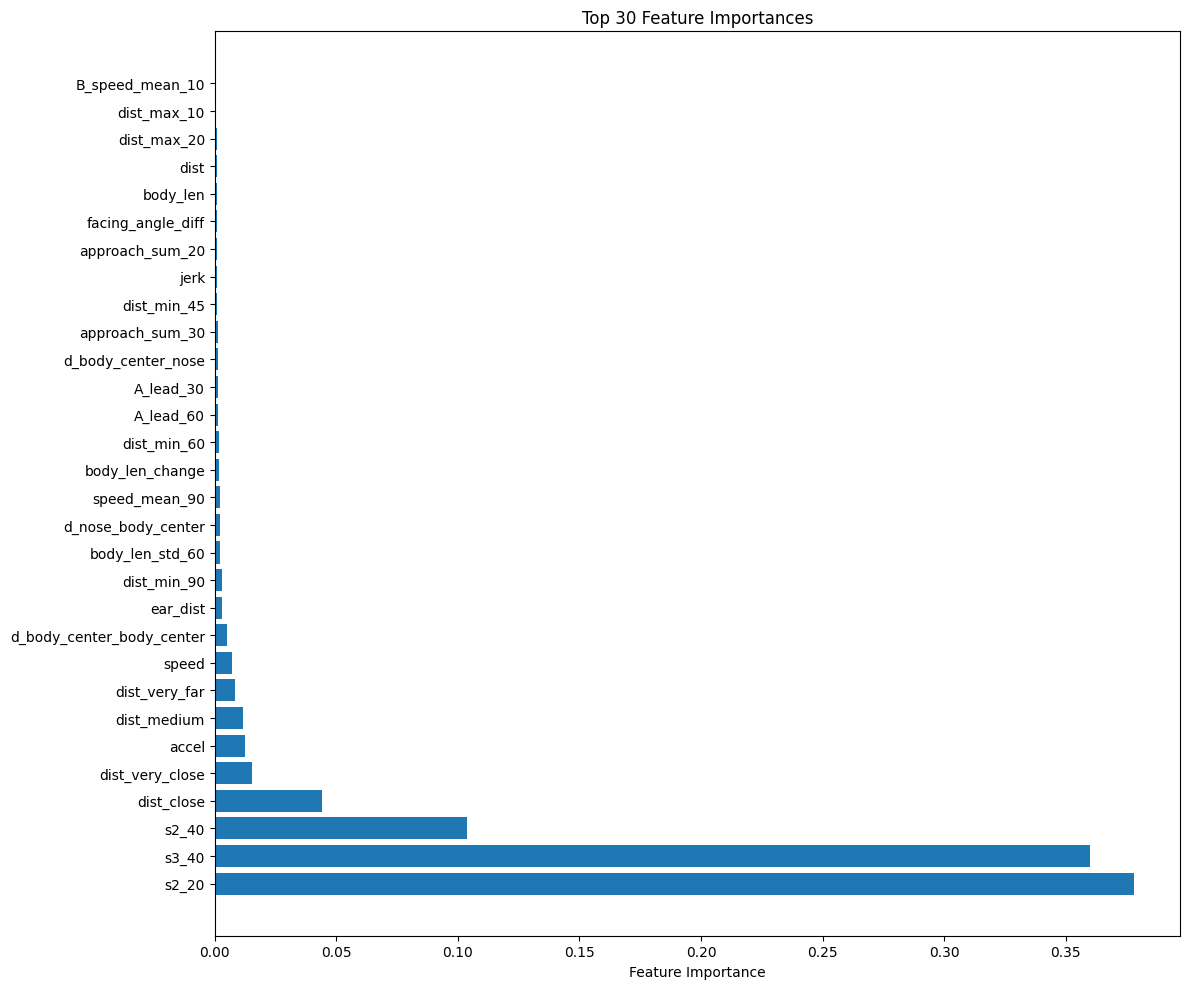


Top 10 features:
  s2_20: 0.3781
  s3_40: 0.3600
  s2_40: 0.1038
  dist_close: 0.0439
  dist_very_close: 0.0155
  accel: 0.0124
  dist_medium: 0.0115
  dist_very_far: 0.0083
  speed: 0.0070
  d_body_center_body_center: 0.0048


In [13]:
# Thêm cell mới sau training để phân tích features
import matplotlib.pyplot as plt

def analyze_feature_importance(models, feature_cols, top_n=30):
    """Phân tích feature importance từ các models"""
    # Tính average importance
    importance_dict = defaultdict(float)
    for model in models:
        importances = model.feature_importances_
        for name, importance in zip(feature_cols, importances):
            importance_dict[name] += importance
    
    # Average
    for name in importance_dict:
        importance_dict[name] /= len(models)
    
    # Sort và lấy top features
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    top_features = sorted_importance[:top_n]
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    names = [x[0] for x in top_features]
    values = [x[1] for x in top_features]
    
    ax.barh(range(len(names)), values)
    ax.set_yticks(range(len(names)))
    ax.set_yticklabels(names)
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'Top {top_n} Feature Importances')
    plt.tight_layout()
    plt.show()
    
    return dict(sorted_importance)

# Gọi hàm sau training
feature_importance = analyze_feature_importance(models, feature_cols, top_n=30)
print("\nTop 10 features:")
for feat, imp in list(feature_importance.items())[:10]:
    print(f"  {feat}: {imp:.4f}")

In [14]:
# Performance summary và suggestions for improvement
print("=" * 80)
print("PERFORMANCE SUMMARY")
print("=" * 80)

# 1. OOF Performance
print(f"\n1. Out-of-Fold Performance:")
print(f"   - OOF F1 Score (non-none): {oof_f1:.4f}")

# 2. Threshold analysis
print(f"\n2. Threshold Analysis:")
print(f"   - Number of actions with thresholds tuned: {len(thresholds)}")
print(f"   - Average threshold: {np.mean(list(thresholds.values())):.3f}")
print(f"   - Threshold range: {min(thresholds.values()):.3f} - {max(thresholds.values()):.3f}")

# 3. Feature analysis
print(f"\n3. Feature Analysis:")
print(f"   - Total features: {len(feature_cols)}")
print(f"   - Top features by importance:")

if 'feature_importance' in locals():
    top_features = list(feature_importance.items())[:5]
    for feat, imp in top_features:
        print(f"     * {feat}: {imp:.4f}")

# 4. Data statistics
print(f"\n4. Data Statistics:")
print(f"   - Training samples: {len(X_train)}")
print(f"   - Test samples: {len(X_test) if 'X_test' in locals() else 0}")
print(f"   - Class distribution:")
for cls, count in y_train.value_counts().items():
    percentage = count / len(y_train) * 100
    print(f"     * {cls}: {count} ({percentage:.1f}%)")

# 5. Model configuration
print(f"\n5. Model Configuration:")
print(f"   - n_estimators: {CFG.model.n_estimators}")
print(f"   - learning_rate: {CFG.model.learning_rate}")
print(f"   - max_depth: {CFG.model.max_depth}")
print(f"   - Using GPU: {'cuda' in str(CFG.model.device)}")
print(f"   - Using class weights: {CFG.use_class_weights}")

# 6. Suggestions for improvement
print(f"\n6. Suggestions for Further Improvement:")
print(f"   - Try increasing max_items in build_dataset() if RAM allows")
print(f"   - Experiment with different frame_step values (1, 2, 3)")
print(f"   - Consider hyperparameter tuning with Optuna or GridSearch")
print(f"   - Add more advanced temporal features (FFT, wavelet transforms)")
print(f"   - Experiment with different XGBoost objective functions")
print(f"   - Consider ensemble with other models (LightGBM, CatBoost)")

print("\n" + "=" * 80)

PERFORMANCE SUMMARY

1. Out-of-Fold Performance:
   - OOF F1 Score (non-none): 0.4024

2. Threshold Analysis:
   - Number of actions with thresholds tuned: 18
   - Average threshold: 0.345
   - Threshold range: 0.103 - 0.743

3. Feature Analysis:
   - Total features: 168
   - Top features by importance:
     * s2_20: 0.3781
     * s3_40: 0.3600
     * s2_40: 0.1038
     * dist_close: 0.0439
     * dist_very_close: 0.0155

4. Data Statistics:
   - Training samples: 3669523
   - Test samples: 294768
   - Class distribution:
     * none: 2895641 (78.9%)
     * sniff: 330904 (9.0%)
     * sniffgenital: 147394 (4.0%)
     * intromit: 70056 (1.9%)
     * attack: 69704 (1.9%)
     * rear: 39603 (1.1%)
     * mount: 25967 (0.7%)
     * sniffbody: 18416 (0.5%)
     * shepherd: 11854 (0.3%)
     * approach: 10958 (0.3%)
     * avoid: 10484 (0.3%)
     * sniffface: 9638 (0.3%)
     * chase: 6610 (0.2%)
     * selfgroom: 5861 (0.2%)
     * dominancemount: 5001 (0.1%)
     * disengage: 4912 (0.1%)
